In [1]:
from pynq import Overlay, allocate
from time import perf_counter_ns
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from typing import Final
from enum import IntEnum
from pathlib import Path

In [2]:
VERSIONS: Final[tuple[int, ...]] = (1, 2, 3, 4)
KERNEL_SIZES: Final[tuple[int, ...]] = (3, 5, 7, 9, 11)

In [3]:
def get_median_filter(size: int) -> np.ndarray:
    if size % 2 == 0:
        raise ValueError(F'Kernel size must be odd. {size} is even.')

    kernel: Final[np.ndarray] = np.ones((size, size), dtype=np.float32) / (size * size)
    return kernel.flatten()

In [4]:
CONTROL: Final[int] = 0x00

IMAGE_OUT: Final[int] = 0x10
IMAGE_IN: Final[int] = 0x18
KERNEL: Final[int] = 0x30

ROWS: Final[int] = 0x20
COLS: Final[int] = 0x28
KERNEL_SIZE: Final[int] = 0x38

STRIDE_ROW: Final[int] = 0x40
STRIDE_COL: Final[int] = 0x48

PADDING: Final[int] = 0x50

In [5]:
class Padding(IntEnum):
    EDGE = 0x01
    REFLECT = 0x02
    ZEROS = 0x04

In [6]:
image_path: Final[Path] = Path('/home/xilinx/jupyter_notebooks/LinearImageFiltering/test.jpeg').resolve()
image: Final[np.ndarray] = cv.cvtColor(cv.imread(str(image_path)), cv.COLOR_BGR2RGB)

grey_image: Final[np.ndarray] = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
rows, cols = grey_image.shape

flat_image: Final[np.ndarray] = grey_image.flatten().astype(np.float32) / 255.0

combined: Final[np.ndarray] = np.hstack((image, cv.cvtColor(grey_image, cv.COLOR_GRAY2RGB)))

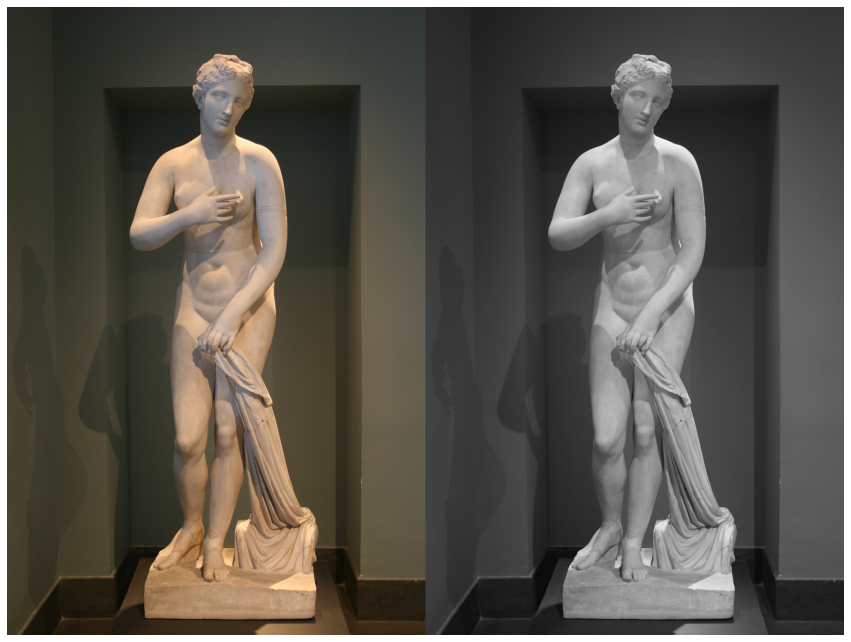

In [7]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(combined);

In [8]:
for version in VERSIONS:
    path = Path(F'/home/xilinx/jupyter_notebooks/LinearImageFiltering/Version{version}/LinearImageFilter.bit').resolve()

    if not path.exists():
        raise FileNotFoundError(F'Version {version} bitstream not found.')

    print(F'Running version {version}...')

    for kernel_size in KERNEL_SIZES:
        # The bitstream is loaded into the PL for every test to ensure consistent results
        overlay = Overlay(str(path))
        ip = overlay.LinearImageFilter

        image_in: Final = allocate(shape=flat_image.shape, dtype=np.float32)
        image_out: Final = allocate(shape=flat_image.shape, dtype=np.float32)

        image_in[:] = flat_image
        image_in.sync_to_device()

        median_kernel: Final[np.ndarray] = get_median_filter(kernel_size)
        kernel: Final = allocate(shape=median_kernel.shape, dtype=np.float32)
        kernel[:] = median_kernel
        kernel.sync_to_device()

        ip.write(IMAGE_IN, image_in.physical_address)
        ip.write(IMAGE_OUT, image_out.physical_address)
        ip.write(KERNEL, kernel.physical_address)

        ip.write(ROWS, rows)
        ip.write(COLS, cols)
        ip.write(KERNEL_SIZE, kernel_size)

        ip.write(STRIDE_ROW, 1)
        ip.write(STRIDE_COL, 1)

        ip.write(PADDING, Padding.REFLECT.value)

        print(F'Linear Filter with kernel size {kernel_size}: ', end='')
        start = perf_counter_ns()

        ip.write(CONTROL, (1 << 0))
        while ip.read(CONTROL) != (1 << 2):
            pass

        stop = perf_counter_ns()

        elapsed_ms = (stop - start) / 1e6
        print(F'{elapsed_ms} ms')

        image_out.sync_from_device()
        filtered_flat_image: Final[np.ndarray] = image_out
        filtered_image: Final[np.ndarray] = (filtered_flat_image.reshape((rows, cols)) * 255.0).astype(np.uint8)

        image_out.freebuffer()
        image_in.freebuffer()
        kernel.freebuffer()

        cv.imwrite(F'/home/xilinx/jupyter_notebooks/LinearImageFiltering/Version{version}/result{kernel_size}x{kernel_size}.jpeg', filtered_image)

Running version 1...


Linear Filter with kernel size 3: 29157.846465 ms
Linear Filter with kernel size 5: 61238.719294 ms
Linear Filter with kernel size 7: 109352.298386 ms
Linear Filter with kernel size 9: 173333.991122 ms
Linear Filter with kernel size 11: 252413.049323 ms
Running version 2...
Linear Filter with kernel size 3: 14131.986799 ms
Linear Filter with kernel size 5: 22194.634345 ms
Linear Filter with kernel size 7: 34288.385699 ms
Linear Filter with kernel size 9: 50413.112391 ms
Linear Filter with kernel size 11: 70568.704034 ms
Running version 3...
Linear Filter with kernel size 3: 13830.44949 ms
Linear Filter with kernel size 5: 21892.414036 ms
Linear Filter with kernel size 7: 33986.621106 ms
Linear Filter with kernel size 9: 50112.05459 ms
Linear Filter with kernel size 11: 70266.000122 ms
Running version 4...
Linear Filter with kernel size 3: 14132.14349 ms
Linear Filter with kernel size 5: 22194.865375 ms
Linear Filter with kernel size 7: 34288.251102 ms
Linear Filter with kernel size 9: 